In [12]:
import pandas as pd
# 讀取檔案
all_df = pd.read_csv("high_diamond_ranked_10min.csv")
all_df = all_df.drop(['gameId'], axis=1)
all_df


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,1,54,0,0,6,4,8,1,1,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,0,14,4,1,2,3,3,1,1,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


In [13]:
import numpy as np

# 把資料分為訓練資料與測試資料 85%訓練 15%測試
mask = np.random.rand(len(all_df)) < 0.85
train_df = all_df[mask]
test_df = all_df[~mask]
len(test_df)

1413

In [14]:
from typing import Tuple
from sklearn import preprocessing
from keras.utils import to_categorical


def feature_preprocessing(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    # 把資料分開成特徵與標籤
    nd_array = df.values
    labels = nd_array[:, 0]  # 標籤
    data = nd_array[:, 1:]  # 特徵

    # 特徵縮放成0~1之間
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # OHE: one-hot encoding
    labels = to_categorical(labels)

    return scaled_data, labels


train_data, train_labels = feature_preprocessing(train_df)
test_data, test_labels = feature_preprocessing(test_df)
test_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

model = Sequential()

model.add(Dense(256, activation=("sigmoid"), input_shape=(38,)))
# model.add(Dropout(0.1))  # 隨機丟棄10%的神經元
model.add(Dense(128, activation=("sigmoid")))  # 隱藏層256個神經元
model.add(Dense(2, activation=("softmax")))  # 輸出層2個神經元
print(model.summary())

"""
隨機梯度下降並設定學習率為 0.01 以及動量為 0.9
學習率表示每次更新的幅度，動量表示前一次更新的幅度
"""
sgd = SGD(lr=0.01, momentum=0.9)
"""
不太確定categorical_crossentropy的意思
優化器用上面的sgd
用準確率來當評估指標
"""
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               9984      
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 2)                 258       
                                                                 
Total params: 43,138
Trainable params: 43,138
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
"""
傳入訓練資料與標籤 驗證資料比例0.3 訓練300次 每次訓練30筆資料
但是不太懂為什麼上面已經設定85%訓練15%測試 這邊又給一次validation_split
上面已經自己分好了這邊再給一次驗證數據的比例 那到底會用我上面自己分好的比例還是用validation_split設定的比例
"""
history = model.fit(
    train_data, train_labels, validation_split=0.3, epochs=300, batch_size=30
)

Epoch 1/300
198/198 [==============================] - 1s 2ms/step - loss: 0.6951 - acc: 0.5275 - val_loss: 0.6736 - val_acc: 0.5209
Epoch 2/300
198/198 [==============================] - 0s 2ms/step - loss: 0.6757 - acc: 0.5773 - val_loss: 0.6485 - val_acc: 0.6028
Epoch 3/300
198/198 [==============================] - 0s 2ms/step - loss: 0.6243 - acc: 0.6564 - val_loss: 0.6451 - val_acc: 0.6169
Epoch 4/300
198/198 [==============================] - 0s 2ms/step - loss: 0.5942 - acc: 0.6785 - val_loss: 0.5797 - val_acc: 0.6961
Epoch 5/300
198/198 [==============================] - 0s 2ms/step - loss: 0.5727 - acc: 0.6927 - val_loss: 0.5559 - val_acc: 0.7169
Epoch 6/300
198/198 [==============================] - 0s 2ms/step - loss: 0.5608 - acc: 0.7025 - val_loss: 0.6525 - val_acc: 0.6370
Epoch 7/300
198/198 [==============================] - 0s 2ms/step - loss: 0.5596 - acc: 0.7098 - val_loss: 0.5363 - val_acc: 0.7358
Epoch 8/300
198/198 [==============================] - 0s 1ms/step - 

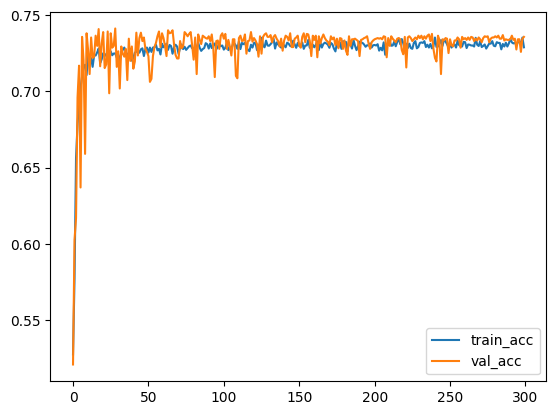

In [21]:
import matplotlib.pyplot as plt

# 輸出圖表
plt.plot(history.history["acc"], label="train_acc")
plt.plot(history.history["val_acc"], label="val_acc")
plt.legend()
plt.show()